# 1. Installating & importing packages and files

In [1]:
#Import packages
import numpy as np
import pandas as pd
import scipy
import os
import json
import pickle
import seaborn as sns
import warnings
import gc
import sklearn
import matplotlib.pyplot as plt
import time

from tqdm import tqdm
import joblib
from sklearn.metrics import mean_squared_error, make_scorer, r2_score
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso, ARDRegression, BayesianRidge
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score, KFold, RandomizedSearchCV, GridSearchCV, GroupKFold
from itertools import combinations
from scipy.linalg import LinAlgWarning

In [2]:
# garbage collector
import gc

In [3]:
# Plotting variance explained for input and output target using the first 1000 singular values
explained_variance_input_1000_svd = np.load("/kaggle/input/multiome-svd-1000-components/train_multi_input_1000_svd_explained_variance_ratio.npz")["arr_0"]
explained_variance_targets_1000_svd = np.load("/kaggle/input/multiome-svd-1000-components/train_multi_targets_1000_svd_explained_variance_ratio.npz")["arr_0"]

In [4]:
train_multi_inputs_idxcol = np.load("/kaggle/input/multimodal-single-cell-as-sparse-matrix/train_multi_inputs_idxcol.npz", allow_pickle=True)
train_multi_targets_idxcol = np.load("/kaggle/input/multimodal-single-cell-as-sparse-matrix/train_multi_targets_idxcol.npz", allow_pickle=True)

# 2. Plots and pre-processing

## 2.1 Plots of explained variance from SVD

[]

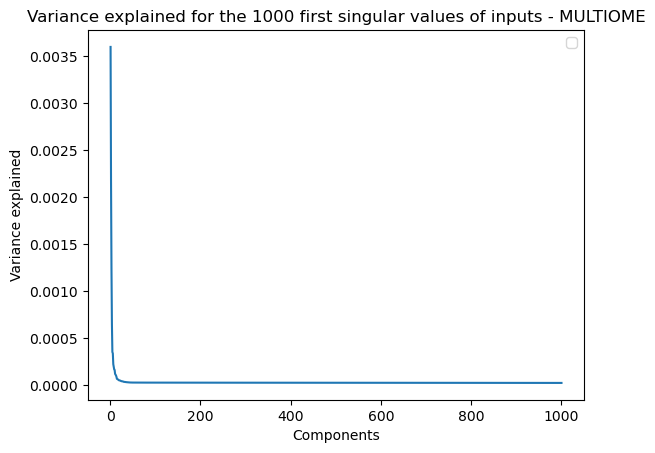

In [5]:
plt.plot(np.arange(1,len(explained_variance_input_1000_svd)+1),explained_variance_input_1000_svd)
plt.xlabel("Components")
plt.ylabel("Variance explained")
plt.title("Variance explained for the 1000 first singular values of inputs - MULTIOME")
plt.legend()
plt.plot()

[]

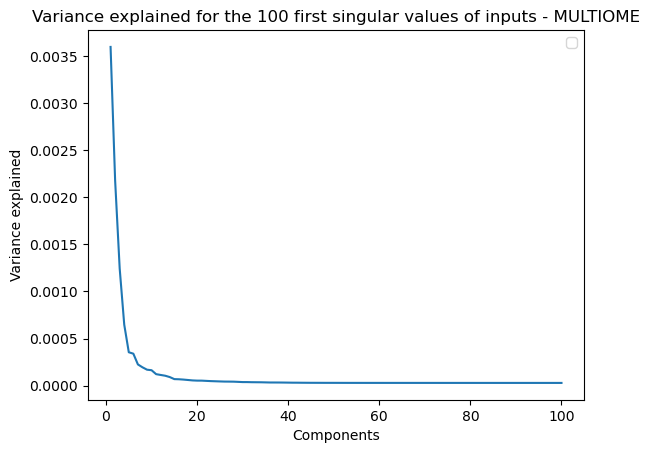

In [6]:
plt.plot(np.arange(1,len(explained_variance_input_1000_svd[:100])+1),explained_variance_input_1000_svd[:100])
plt.xlabel("Components")
plt.ylabel("Variance explained")
plt.title("Variance explained for the 100 first singular values of inputs - MULTIOME")
plt.legend()
plt.plot()

[]

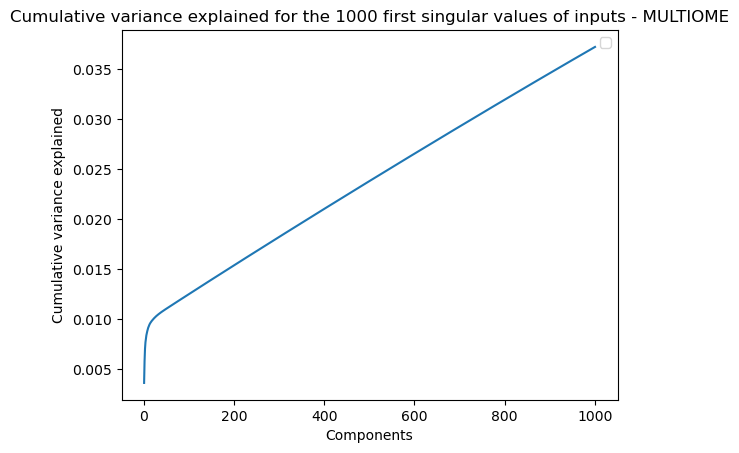

In [7]:
plt.plot(np.arange(1,len(explained_variance_input_1000_svd)+1),np.cumsum(explained_variance_input_1000_svd))
plt.xlabel("Components")
plt.ylabel("Cumulative variance explained")
plt.title("Cumulative variance explained for the 1000 first singular values of inputs - MULTIOME")
plt.legend()
plt.plot()

[]

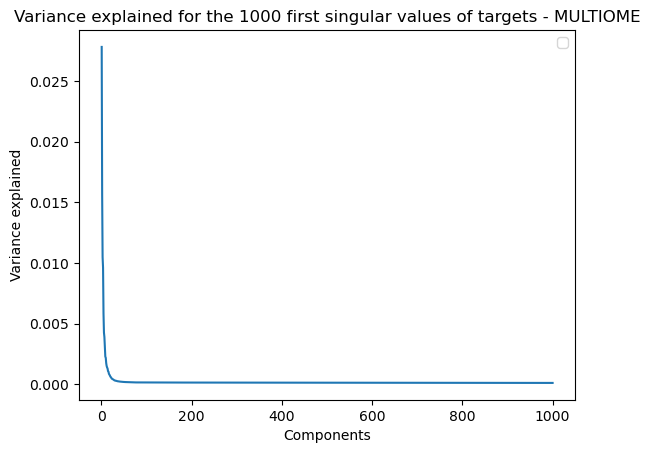

In [8]:
plt.plot(np.arange(1,len(explained_variance_targets_1000_svd)+1),explained_variance_targets_1000_svd)
plt.xlabel("Components")
plt.ylabel("Variance explained")
plt.title("Variance explained for the 1000 first singular values of targets - MULTIOME")
plt.legend()
plt.plot()

[]

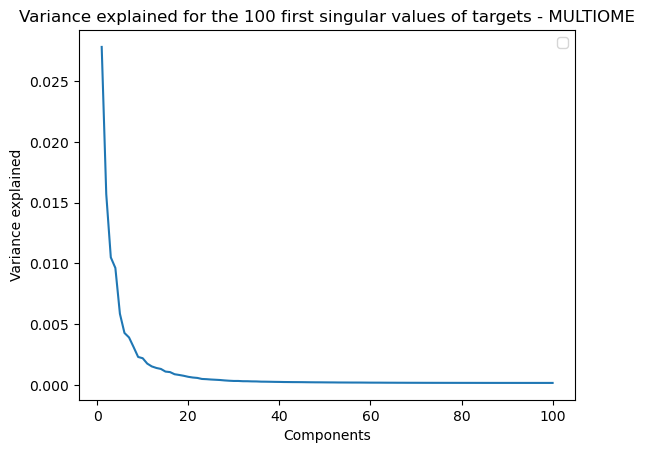

In [9]:
plt.plot(np.arange(1,len(explained_variance_targets_1000_svd[:100])+1),explained_variance_targets_1000_svd[:100])
plt.xlabel("Components")
plt.ylabel("Variance explained")
plt.title("Variance explained for the 100 first singular values of targets - MULTIOME")
plt.legend()
plt.plot()

[]

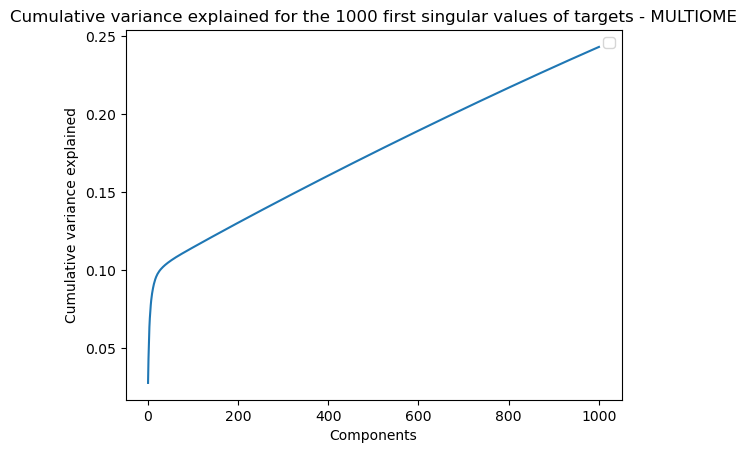

In [10]:
plt.plot(np.arange(1,len(explained_variance_targets_1000_svd)+1),np.cumsum(explained_variance_targets_1000_svd))
plt.xlabel("Components")
plt.ylabel("Cumulative variance explained")
plt.title("Cumulative variance explained for the 1000 first singular values of targets - MULTIOME")
plt.legend()
plt.plot()

In [11]:
del explained_variance_input_1000_svd
del explained_variance_targets_1000_svd
gc.collect()

6000

## 2.2 Opening of the dataset and basic checks

In [12]:
# Opening input SVD matrix
train_multi_input_500_svd = np.load("/kaggle/input/multiome-svd-500-components/train_multi_input_500_svd.npz")["arr_0"]
train_multi_targets_500_svd = np.load("/kaggle/input/multiome-svd-500-components/train_multi_targets_500_svd.npz")["arr_0"]

In [13]:
# Checking if some columns are constant
print(np.sum(np.all(train_multi_input_500_svd == train_multi_input_500_svd[0,:], axis = 0)))
print(np.sum(np.all(train_multi_targets_500_svd == train_multi_targets_500_svd[0,:], axis = 0)))

0
0


## 2.3 Correlation pre-processing

In [14]:
# Function to compute the correlation matrix between our inputs and our targets
def correlation_btw_input_targets(a_mat, b_mat):
    residuals_a = a_mat - a_mat.mean(axis=0, keepdims=True)#removing the columns' means to each column values
    residuals_b = b_mat - b_mat.mean(axis=0, keepdims=True)#removing the columns' means to each column values
    a_residual_sums = (residuals_a*residuals_a).sum(axis=0)
    b_residual_sums = (residuals_b*residuals_b).sum(axis=0)
    residual_products = np.dot(residuals_a.T, residuals_b)
    sum_products = np.sqrt(np.outer(a_residual_sums, b_residual_sums))
    correlations = residual_products / sum_products
    # Deleting the unnecessary variables from the RAM
    del a_mat
    del b_mat
    del residuals_a
    del residuals_b
    del a_residual_sums
    del b_residual_sums
    del residual_products
    del sum_products
    gc.collect()
    return correlations

In [15]:
correlations = correlation_btw_input_targets(train_multi_input_500_svd, train_multi_targets_500_svd)

<AxesSubplot:>

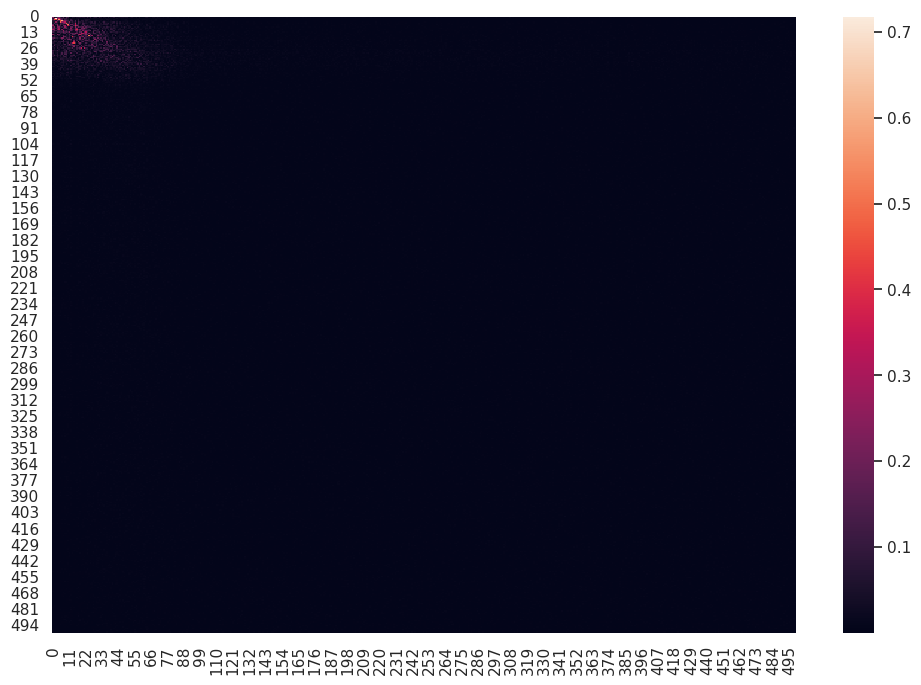

In [16]:
# Ploting a heatmap of the correlation
sns.set(rc={'figure.figsize':(12,8)})
sns.heatmap(np.abs(correlations))

In [17]:
input_to_keep = 40
targets_to_keep = 40

<AxesSubplot:>

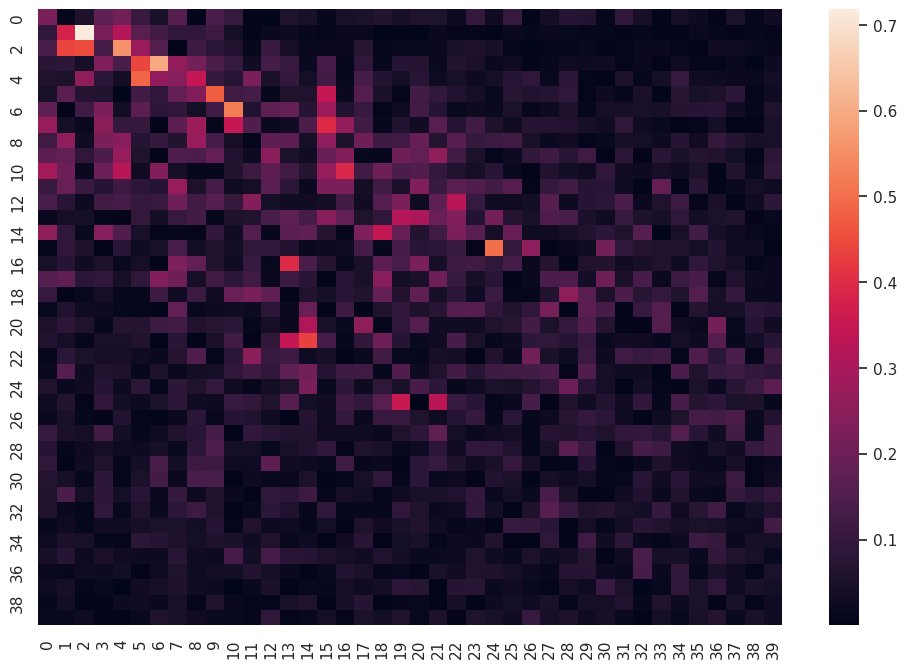

In [18]:
# New ploting of the heatmap for less singular vectors of features and targets
correlations = correlation_btw_input_targets(train_multi_input_500_svd[:,:input_to_keep], 
                                             train_multi_targets_500_svd[:,:targets_to_keep])
# Ploting a heatmap of the correlation
sns.set(rc={'figure.figsize':(12,8)})
sns.heatmap(np.abs(correlations))

## 2.4 Kept features and targets

In [19]:
input_values = train_multi_input_500_svd[:,:input_to_keep]
targets_values = train_multi_targets_500_svd[:,:targets_to_keep]
del train_multi_input_500_svd
del train_multi_targets_500_svd
gc.collect()

36

In [20]:
input_df = pd.DataFrame(data = input_values, 
                  index = train_multi_inputs_idxcol["index"], 
                  columns = [str(i)+"_input" for i in range(input_to_keep)])
targets_df = pd.DataFrame(data = targets_values, 
                  index = train_multi_targets_idxcol["index"], 
                  columns = [str(i)+"_targets" for i in range(targets_to_keep)])
del input_values
del targets_values
gc.collect()

37

In [21]:
# Keeping the 10 highest correlated DNA singular features for each RNA singular targets
features_index_2_keep = np.argsort(np.abs(correlations), axis=0)[-10:,:].T

## 2.5 Metadata opening information and checks good repartition of data over donors and days

In [22]:
# Reading the metadata file
metadata = pd.read_csv("/kaggle/input/open-problems-multimodal/metadata.csv")
# Keeping the metadata of our citeSeq data and droping useless column
metadata = metadata[metadata["cell_id"].isin(train_multi_inputs_idxcol["index"])].drop(["technology"], axis=1)
# One Hot encoding for cell-types
df_cell_type_dummies = pd.get_dummies(metadata.cell_type)
cell_types = np.unique(metadata.cell_type.to_numpy()).tolist()
metadata = metadata.drop(["cell_type"], axis=1)
metadata["group"] = metadata["day"].astype(str)+"_"+metadata["donor"].astype(str)

In [23]:
metadata

,cell_id,day,donor,group
152603,56390cf1b95e,2,32606,2_32606
152604,fc0c60183c33,2,32606,2_32606
152605,9b4a87e22ad0,2,32606,2_32606
152606,81cccad8cd81,2,32606,2_32606
152607,15cb3d85c232,2,32606,2_32606
...,...,...,...,...
274379,063cead1a4ea,7,31800,7_31800
274380,553bca99ba78,7,31800,7_31800
274381,00783f28b463,7,31800,7_31800
274382,e7abb1a0f251,7,31800,7_31800


In [24]:
# Repartition of the 3 donors over the complete dataset
donors, donor_counts = np.unique(metadata["donor"],return_counts=True)
donor_counts/np.sum(donor_counts)

array([0.33410734, 0.34778464, 0.31810802])

In [25]:
# Repartition of days over the complete dataset
days, day_counts = np.unique(metadata["day"],return_counts=True)
day_counts/np.sum(day_counts)

array([0.22569897, 0.27198845, 0.29387778, 0.2084348 ])

In [26]:
# Repartition of group (donor,day) over the complete dataset
groups, group_counts = np.unique(metadata["group"],return_counts=True)
(group_counts/np.sum(group_counts)).reshape([3,4])

array([[0.09021918, 0.06691397, 0.06856582, 0.08462177],
       [0.10671877, 0.0806479 , 0.08879387, 0.10188594],
       [0.10319798, 0.07047252, 0.07226596, 0.06569632]])

## 2.6 Create final train and test datasets

In [27]:
df_database = metadata.join(df_cell_type_dummies).join(input_df, on="cell_id").join(targets_df, on="cell_id")
df_train = df_database[df_database["day"]!=7]
df_test = df_database[df_database["day"]==7]

In [28]:
df_database

,cell_id,day,donor,group,BP,EryP,HSC,MasP,MkP,MoP,...,30_targets,31_targets,32_targets,33_targets,34_targets,35_targets,36_targets,37_targets,38_targets,39_targets
152603,56390cf1b95e,2,32606,2_32606,0,0,0,0,0,0,...,-0.895247,1.950204,0.398738,6.106205,-1.826311,0.203952,3.663262,-2.565385,-0.062804,-7.147138
152604,fc0c60183c33,2,32606,2_32606,0,0,1,0,0,0,...,-4.245243,8.080447,2.193192,6.422708,-0.658925,2.489529,-3.523815,-1.881789,2.340034,-0.581293
152605,9b4a87e22ad0,2,32606,2_32606,0,0,0,1,0,0,...,4.693424,2.098315,-3.740669,2.077569,1.923951,2.322400,-5.129830,-1.301605,0.100615,-3.835785
152606,81cccad8cd81,2,32606,2_32606,0,0,1,0,0,0,...,-2.081603,0.006938,0.018547,-1.178010,1.887824,-7.510479,-1.319409,-1.395976,-3.405677,0.970925
152607,15cb3d85c232,2,32606,2_32606,0,0,0,0,1,0,...,-1.251107,1.717856,-6.352590,-3.796247,1.079986,0.067629,-1.964458,1.688243,2.059722,-3.651993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274379,063cead1a4ea,7,31800,7_31800,0,0,1,0,0,0,...,1.188267,-3.146415,4.226768,0.220194,-1.389867,3.624359,-3.811886,-0.662942,-8.182001,1.622875
274380,553bca99ba78,7,31800,7_31800,0,0,0,1,0,0,...,-9.933636,-3.626710,-0.160677,2.191283,-0.234477,2.131776,-2.369477,-0.867645,-5.951002,2.123084
274381,00783f28b463,7,31800,7_31800,0,0,0,0,0,0,...,2.918802,3.407279,-0.568507,-1.637435,-2.053125,5.148231,-8.183878,1.912434,4.724936,-3.196970
274382,e7abb1a0f251,7,31800,7_31800,0,1,0,0,0,0,...,2.254739,-5.538095,-0.057370,4.481005,-2.514055,-2.902745,-4.495811,-6.214432,6.672813,-4.915574


# 3. Objective functions

In [29]:
def correlation_score(y_true, y_pred):
    """Scores the predictions according to the competition rules. 
    
    It is assumed that the predictions are not constant.
    
    Returns the average of each sample's Pearson correlation coefficient"""
    if type(y_true) == pd.DataFrame: y_true = y_true.values
    if type(y_pred) == pd.DataFrame: y_pred = y_pred.values
    corrsum = 0
    for i in range(len(y_true)):
        corrsum += np.corrcoef(y_true[i], y_pred[i])[1, 0]
    return corrsum / len(y_true)

In [30]:
scoring = {"MSE": make_scorer(mean_squared_error, greater_is_better=False), "Correlation": make_scorer(r2_score, greater_is_better=True)}

# 4. Importing real targets & computing loss between reduced targets and real targets

## 4.1 Importing

In [31]:
df_real_target = pd.read_hdf("/kaggle/input/open-problems-multimodal/train_multi_targets.h5")#target

In [32]:
train_multi_targets_500_svd_VT = np.load("/kaggle/input/multiome-svd-500-components/train_multi_targets_500_svd_VT.npz")["arr_0"]
train_multi_targets_500_svd_VT = train_multi_targets_500_svd_VT[:targets_to_keep,:]

## 4.2 Testing

In [33]:
approximated_gene_expression_from_svd = np.dot(df_database[df_database.columns[-targets_to_keep:]].to_numpy(),train_multi_targets_500_svd_VT)
pd_approximated_targets_from_svd = pd.DataFrame(data = approximated_gene_expression_from_svd, 
                                                index = train_multi_targets_idxcol["index"], 
                                                columns = train_multi_targets_idxcol["columns"])
del approximated_gene_expression_from_svd
gc.collect()

100

In [34]:
correlation_score(df_real_target, pd_approximated_targets_from_svd)

0.6780683078799105

In [35]:
mean_squared_error(df_real_target, pd_approximated_targets_from_svd)

1.9248755

In [36]:
del pd_approximated_targets_from_svd
del df_real_target
gc.collect()

63

# 4. Models and training

In [37]:
models = {
    'Linear Regression': LinearRegression(),
    'ElasticNet': ElasticNet(),
    'Ridge Regression': Ridge(),
    'Lasso': Lasso(),
    'BayesianRidge': BayesianRidge(),
    'ARDRegression': ARDRegression()
}

'XGBoost Regressor': XGBRegressor(),
'LightGBM Regressor': LGBMRegressor(),
'SVM: SVR(),

In [38]:
df_train = df_database[df_database["day"]!=7]
df_test = df_database[df_database["day"]==7]

In [39]:
combs_donors = [[13176], [31800], [32606], [13176, 31800], [31800, 32606], [13176, 32606], [13176, 31800, 32606]]

In [40]:
targets_columns = df_database.columns[-targets_to_keep:]

In [41]:
gc.collect()

105

In [42]:
hyperparams = {
    'Linear Regression': {
        'fit_intercept': [True, False],
        'normalize': [True, False],
        'copy_X': [False]
    },
    'ElasticNet': {
        'alpha': [0.001, 0.01, 0.1, 1, 10, 100],
        'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
        'fit_intercept': [True, False],
        'normalize': [True, False],
        'precompute': [True, False],
        'max_iter': [1000, 5000, 10000],
        'tol': [0.0001, 0.001, 0.01],
        'warm_start': [True, False],
        'positive': [True, False],
        'selection': ['cyclic', 'random'],
        'copy_X': [False]
    },
    'Ridge Regression': {
        'alpha': [0.001, 0.01, 0.1, 1, 10, 100],
        'fit_intercept': [True, False],
        'normalize': [True, False],
        'max_iter': [1000, 5000, 10000],
        'tol': [0.0001, 0.001, 0.01, 0.1],
        'solver': ['auto'],
        'copy_X': [False]
    },
    'Lasso': {
        'alpha': [0.001, 0.01, 0.1, 1, 10, 100],
        'fit_intercept': [True, False],
        'normalize': [True, False],
        'precompute': [True, False],
        'max_iter': [1000, 5000, 10000],
        'tol': [0.0001, 0.001, 0.01],
        'warm_start': [True, False],
        'positive': [True, False],
        'selection': ['cyclic', 'random'],
        'copy_X': [False]
    },
    'BayesianRidge': {
        'n_iter': [100, 300, 500],
        'tol': [0.001, 0.0001, 0.00001],
        'alpha_1': [1e-7, 1e-6, 1e-5],
        'alpha_2': [1e-7, 1e-6, 1e-5],
        'lambda_1': [1e-7, 1e-6, 1e-5],
        'lambda_2': [1e-7, 1e-6, 1e-5],
        'compute_score': [True, False],
        'fit_intercept': [True, False],
        'normalize': [True, False],
        'verbose': [False],
        'copy_X': [False]
    },
    'ARDRegression': {
        'n_iter': [100, 300, 500],
        'tol': [0.001, 0.0001, 0.00001],
        'alpha_1': [1e-7, 1e-6, 1e-5],
        'alpha_2': [1e-7, 1e-6, 1e-5],
        'lambda_1': [1e-7, 1e-6, 1e-5],
        'lambda_2': [1e-7, 1e-6, 1e-5],
        'threshold_lambda': [1000, 5000, 10000],
        'fit_intercept': [True, False],
        'normalize': [True, False],
        'copy_X': [False],
        'verbose': [False],
        'compute_score': [True, False]
    }
}

In [43]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.filterwarnings(action='ignore', category=LinAlgWarning, module='sklearn')

In [44]:
trained_models_with_results = {}
os.mkdir("/kaggle/working/models_files/")

In [45]:
combs_donors_test = [[13176], [13176, 31800], [13176, 31800, 32606]]

In [46]:
for comb_donor in combs_donors_test:
    gc.collect()
    df_train_temp = df_train[df_train["donor"].isin(comb_donor)]
    df_test_temp = df_database[df_database["cell_id"].isin(df_train_temp["cell_id"])==False]
    trained_models_dict = {}
    for model in models:
        gc.collect()
        groups = df_train_temp["group"].to_numpy()
        gkf = GroupKFold(n_splits=np.unique(groups).shape[0])
        train_predictions = []
        test_predictions = []
        print("Train on", comb_donor, "using", model)
        for i in range(targets_to_keep):
            gc.collect()
            target_column_name = str(i)+'_targets'
            features = [str(item)+"_input" for item in features_index_2_keep[i]]+cell_types
            models_temp = RandomizedSearchCV(estimator=models.copy()[model], 
                                       param_distributions=hyperparams[model], 
                                       n_iter=20,
                                       scoring=scoring,
                                       refit='MSE',
                                       cv=gkf.split(df_train_temp[features], df_train_temp[target_column_name], groups=groups),
                                       random_state=42,
                                       return_train_score=True)
            models_temp.fit(df_train_temp[features], df_train_temp[target_column_name])
            train_predictions.append(models_temp.predict(df_train_temp[features]).tolist())
            test_predictions.append(models_temp.predict(df_test_temp[features]).tolist())
            joblib.dump(models_temp.best_estimator_, "/kaggle/working/models_files/model_"+str(comb_donor)+"_"+model+"_"+target_column_name+".pkl") 
        trained_models_dict[model] = {
            "train_predictions": np.array(train_predictions),
            "test_predictions": np.array(test_predictions)
        }
        print("Training with CV over")
        time.sleep(3)
        gc.collect()
        time.sleep(3)
    trained_models_with_results[str(comb_donor)] = trained_models_dict

Train on [13176] using Linear Regression
Training with CV over
Train on [13176] using ElasticNet
Training with CV over
Train on [13176] using Ridge Regression
Training with CV over
Train on [13176] using Lasso
Training with CV over
Train on [13176] using BayesianRidge
Training with CV over
Train on [13176] using ARDRegression
Training with CV over
Train on [13176, 31800] using Linear Regression
Training with CV over
Train on [13176, 31800] using ElasticNet
Training with CV over
Train on [13176, 31800] using Ridge Regression
Training with CV over
Train on [13176, 31800] using Lasso
Training with CV over
Train on [13176, 31800] using BayesianRidge
Training with CV over
Train on [13176, 31800] using ARDRegression
Training with CV over
Train on [13176, 31800, 32606] using Linear Regression
Training with CV over
Train on [13176, 31800, 32606] using ElasticNet
Training with CV over
Train on [13176, 31800, 32606] using Ridge Regression
Training with CV over
Train on [13176, 31800, 32606] usin

In [47]:
with open('/kaggle/working/result_dictionnary.pickle', 'wb') as outfile:
    pickle.dump(trained_models_with_results, outfile, protocol=pickle.HIGHEST_PROTOCOL)
gc.collect()

21